# Topic Modeling Discovery

In [1]:
# Basics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pickle 

# nltk
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.pipeline import Pipeline

#sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# spacy
import spacy

# corex
from corextopic import corextopic as ct
from corextopic import vis_topic as vt

from preprocessing_funcs import clean_tweet, get_hashtags, get_emojis

In [2]:
with open('../data_files/processed_tweets.pickle', 'rb') as read_file:
    tweets = pickle.load(read_file)

In [3]:
tweets.head()

,text,processed
0,#IslamKills Are you trying to say that there w...,islam kill try say terrorist attack europe ref...
1,"Clinton: Trump should’ve apologized more, atta...",clinton trump apologize attack little
2,RT @ltapoll: Who was/is the best president of ...,well president past retweet
3,RT @jww372: I don't have to guess your religio...,guess religion christmas aftermath
4,RT @Shareblue: Pence and his lawyers decided w...,pence lawyer decide official email public can see


In [4]:
tweets.tail()

,text,processed
203477,"RT @AndreaChalupa: In intel circles, the story...",intel circle story go fsb film trump orgy russ...
203478,RT @KansasCityDNews: Tonganoxie police: Middle...,tonganoxie police middle school girl sexually ...
203479,RT @signsinyork: Getting the right #company lo...,get right company logo business get message ac...
203480,The Latest: Obama affirms continuity of ties w...,late obama affirm continuity tie canada
203481,RT @futureguru100: U cant just Upload a CD onl...,u can not upload cd online product work u get ...


In [5]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203482 entries, 0 to 203481
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   text       203482 non-null  object
 1   processed  203482 non-null  object
dtypes: object(2)
memory usage: 3.1+ MB


In [6]:
tweets.head()

,text,processed
0,#IslamKills Are you trying to say that there w...,islam kill try say terrorist attack europe ref...
1,"Clinton: Trump should’ve apologized more, atta...",clinton trump apologize attack little
2,RT @ltapoll: Who was/is the best president of ...,well president past retweet
3,RT @jww372: I don't have to guess your religio...,guess religion christmas aftermath
4,RT @Shareblue: Pence and his lawyers decided w...,pence lawyer decide official email public can see


In [7]:
proc_tweets = tweets.processed

## KMeans

In [8]:
%%time

tfidfconvert = TfidfVectorizer(use_idf=True, smooth_idf=True, max_features=60000, stop_words='english')
tweets_transformed = tfidfconvert.fit_transform(proc_tweets)

CPU times: user 1.72 s, sys: 54.4 ms, total: 1.78 s
Wall time: 1.78 s


In [9]:
%%time
inertias = []

for k_ in np.arange(1, 21):
    km = KMeans(n_clusters=k_)
    km.fit(tweets_transformed)
    inertias.append(km.inertia_)

CPU times: user 1h 5min 37s, sys: 2min 12s, total: 1h 7min 50s
Wall time: 8min 38s


In [10]:
len(inertias)

20

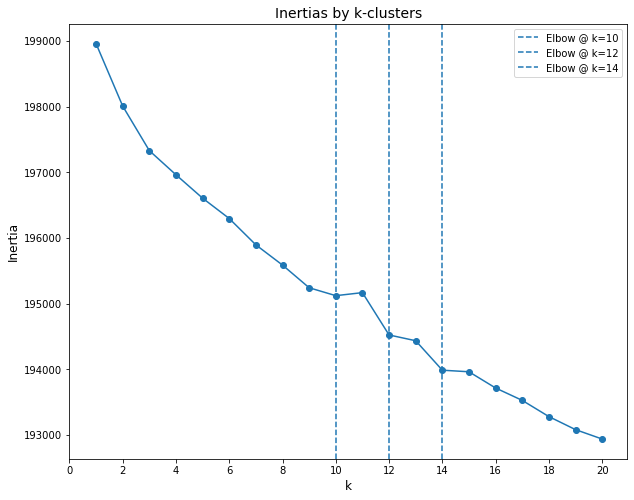

In [18]:
%matplotlib inline
plt.figure(figsize=(10, 8))
plt.plot(np.arange(1, 21), inertias, marker='o')
plt.axvline(x=10, ls='--', label='Elbow @ k=10')
plt.axvline(x=12, ls='--', label='Elbow @ k=12')
plt.axvline(x=14, ls='--', label='Elbow @ k=14')
plt.xticks(np.arange(0, 22, step=2))
plt.title('Inertias by k-clusters', fontsize=14)
plt.ylabel("Inertia", fontsize=12)
plt.xlabel('k', fontsize=12)
plt.legend();

## Topic Modeling

In [19]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

### LSA

Will start with 8 topics - the most pronounced first elbow from above.

In [20]:
vectorizer = TfidfVectorizer(use_idf=True, 
                             smooth_idf=True, 
                             max_features=60000,
                             stop_words='english')

svd_model = TruncatedSVD(n_components=10, 
                         algorithm='randomized',
                         n_iter=100,
                         random_state=42)

# pipeline of tf-idf + SVD, fit and applied to docs: 

svd_transformer = Pipeline([('tfidf', vectorizer),
                           ('svd', svd_model)])

svd_matrix = svd_transformer.fit_transform(proc_tweets)

In [21]:
terms = vectorizer.get_feature_names()

display_topics(svd_model, terms, 10)


Topic  0
trump, donald, hillary, clinton, real, president, america, say, make, politic

Topic  1
hillary, clinton, email, debate, campaign, obama, thing, trust, crook, know

Topic  2
make, america, people, great, like, obama, know, say, good, love

Topic  3
make, america, great, hillary, real, donald, wake, clinton, phrase, hate

Topic  4
president, obama, trump, run, politic, say, news, america, maga, tcot

Topic  5
debate, say, topic, reject, politic, alternative, gop, night, america, clinton

Topic  6
obama, say, real, tcot, donald, america, pjnet, islam, news, kill

Topic  7
know, obama, right, real, donald, tcot, pjnet, debate, president, america

Topic  8
know, say, right, make, love, good, phrase, trump, hate, great

Topic  9
black, live, matt, know, love, right, trump, clinton, new, white


Try again with CountVectorizer

In [22]:
vectorizer = CountVectorizer(max_features=60000,
                             binary=True, 
                             stop_words='english')

svd_model = TruncatedSVD(n_components=10, 
                         algorithm='randomized',
                         n_iter=200,
                         random_state=42)

# pipeline of tf-idf + SVD, fit and applied to docs: 

svd_transformer = Pipeline([('cv', vectorizer),
                           ('svd', svd_model)])

svd_matrix = svd_transformer.fit_transform(proc_tweets)

In [23]:
terms = vectorizer.get_feature_names()

display_topics(svd_model, terms, 10)


Topic  0
trump, donald, hillary, clinton, real, say, president, obama, politic, america

Topic  1
hillary, clinton, obama, email, campaign, fbi, say, debate, crook, lie

Topic  2
obama, make, say, america, people, like, tcot, president, pjnet, black

Topic  3
donald, real, make, hillary, america, great, people, like, wake, tcot

Topic  4
obama, donald, real, hillary, president, barack, michelle, administration, isis, iran

Topic  5
clinton, donald, make, real, america, politic, great, news, new, email

Topic  6
say, people, donald, real, like, black, know, live, thing, matt

Topic  7
people, like, black, live, clinton, know, white, matt, think, look

Topic  8
tcot, america, pjnet, ccot, wake, party, gop, mt, maga, tea

Topic  9
new, black, news, live, matt, post, man, time, white, woman


Feels like there's a bit more variety in the CountVectorizer version.

Hashtag Meanings
- tcot = Top Conservatives on Twitter
- ccot = Christina Conservatives on Twitter
- pjnet = Patriot Journalist Network 

### NMF

In [24]:
vectorizer = CountVectorizer(max_features=60000,
                             binary=True, 
                             stop_words='english')

nmf_model = NMF(n_components=10)

# pipeline of tf-idf + SVD, fit and applied to docs: 

nfm_transformer = Pipeline([('cv', vectorizer),
                           ('nmf', nmf_model)])

nmf_matrix = nfm_transformer.fit_transform(proc_tweets)

In [25]:
terms = vectorizer.get_feature_names()

display_topics(nmf_model, terms, 10)


Topic  0
trump, president, politic, maga, donald, supporter, medium, debate, poll, train

Topic  1
hillary, crook, thing, trust, lie, maga, prison, debate, want, benghazi

Topic  2
make, great, hate, america, phrase, president, good, let, sure, day

Topic  3
donald, real, trump, need, america, time, potus, mike, thank, great

Topic  4
obama, president, barack, michelle, isis, politic, american, administration, iran, world

Topic  5
clinton, politic, email, campaign, foundation, fbi, debate, poll, state, wikileaks

Topic  6
say, know, good, politic, want, thing, election, woman, mean, time

Topic  7
people, like, know, thing, look, think, want, twitter, good, need

Topic  8
america, tcot, pjnet, wake, ccot, party, maga, mt, tea, gop

Topic  9
black, new, news, live, matt, post, man, time, white, day


Pretty similar to LSA

### Corex

[lecture example notebook](https://github.com/scrapfishies/onl20_ds4/blob/master/curriculum/project-04/fancy-nlp/corex/CorEx.ipynb)

In [26]:
vectorizer = CountVectorizer(max_features=60000,
                             token_pattern="\\b[a-z][a-z]+\\b",
                             binary=True,
                             stop_words='english')

doc_word = vectorizer.fit_transform(proc_tweets)
words = list(np.asarray(vectorizer.get_feature_names()))

In [27]:
topic_model = ct.Corex(n_hidden=10, 
                       words=words,
                       max_iter=200, 
                       seed=42)


topic_model.fit(doc_word, words=words, docs=proc_tweets)

In [28]:
# Print all topics from the CorEx topic model
topics = topic_model.get_topics()
for n, topic in enumerate(topics):
    topic_words, _ = zip(*topic)
    print('{}: '.format(n) + ', '.join(topic_words))

0: trump, hillary, clinton, donald, real, politic, campaign, maga, poll, president
1: merkel, muss, die, ist, das, es, nowplaying, sie, ft, ich
2: tcot, pjnet, islam, ccot, mt, kill, refugee, muslim, terrorist, america
3: obama, email, fbi, news, cruz, ted, russia, state, foundation, wikileaks
4: police, black, matt, live, tea, officer, party, shoot, color, oscar
5: guide, thanksgiving, survival, drain, swamp, censorship, cyber, saudi, jadedbypolitics, stein
6: american, white, midnight, house, law, anti, illegal, school, immigration, leader
7: new, gift, politician, idea, york, hall, album, podcast, butihate, ilove
8: christmas, aftermath, happy, birthday, abrams, jenn, santa, girl, merry, halloween
9: make, like, look, great, people, thing, hate, good, know, feel


These topics look more promising - much more diverse

In [30]:
# Let's check out topic : graphics
topic_model.get_top_docs(topic=9, n_docs=10)

[('family sasha obama land job seafood joint malia obama smoke joint lollapalooza',
  0.0),
 ('jimmy fallon wear surgical mask interview hillary clinton', 0.0),
 ('bachman turner hangoverdrive drunkbands midnight', 0.0),
 ('dea reverse kratom ban stun victory warondrugs drugwar health drug', 0.0),
 ('thing people twitter like full anonymity fb booby gifs really drive home tw',
  0.0),
 ('hadenough taxingtyrants r u ready ctcomeback join us', 0.0),
 ('family sasha obama land job seafood joint old sister smoke joint lollapalooza',
  0.0),
 ('local news coverage prominent democrat michigan arrest morning death threat jimmy fallon intervi',
  0.0),
 ('iamthankfulfor sis dccciv always good whenever need vent', 0.0),
 ('reallifemagicspells instill common sense someone complete comedic sound effect feel beat',
  0.0)]

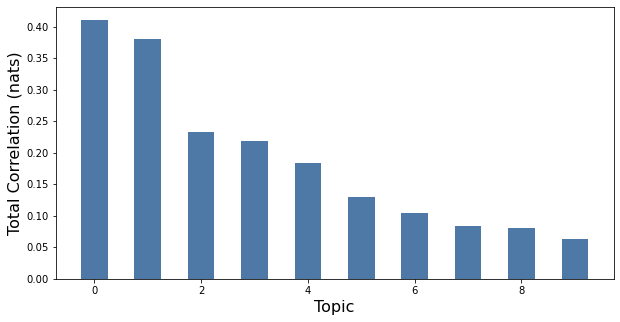

In [31]:
plt.figure(figsize=(10,5))
plt.bar(range(topic_model.tcs.shape[0]), topic_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16)
plt.show()

Testing some anchors based on the topic results

In [32]:
topics = [['donald', 'trump', 'maga'],                                             # trump stuff
          ['hillary', 'clinton'],                                                  # hillary stuff
          ['merkel', 'muss', 'die', 'ist', 'ich', 'das'],                          # german stuff
          ['color', 'blm', 'black', 'matt', 'oscar', 'racism', 'blacktwitter'],    # BLM/race stuff
          ['police', 'officer', 'shoot'],                                          # police stuff
          ['obama', 'barack'],                                                     # obama stuff
          ['isis', 'muslim', 'islam']                                              # isis/islam stuff
         ]

len(topics)

7

Will plot out 7 anchors and let CorEx decide the rest

In [34]:
topic_model = ct.Corex(n_hidden=10, 
                       words=words,
                       max_iter=200, 
                       seed=42)

topic_model.fit(doc_word, words=words, docs=proc_tweets, 
                anchors=topics, anchor_strength=5)

In [35]:
# Print all topics from the CorEx topic model
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_ = zip(*topic)
    print('{}: '.format(n) + ', '.join(topic_words))

0: trump, donald, maga, real, president, supporter, politic, train, rally, headline
1: hillary, clinton, email, campaign, crook, foundation, fbi, trust, wikileaks, benghazi
2: die, merkel, muss, ist, das, ich, sie, es, mit, den
3: black, matt, color, racism, oscar, blm, blacktwitter, live, white, oscars
4: police, shoot, officer, cop, san, suspect, nodapl, arrest, pipeline, dakota
5: obama, barack, michelle, administration, admin, legacy, iran, hussein, malia, pres
6: islam, isis, muslim, kill, refugee, brussels, prayforbrussels, terrorist, opiceisis, iceisis
7: tcot, pjnet, ccot, cruz, mt, america, tea, ted, reject, gop
8: news, election, medium, poll, post, state, new, voter, cnn, report
9: midnight, play, nowplaying, music, game, gt, ft, tim, sport, song


In [37]:
# Let's check out topic : graphics
topic_model.get_top_docs(topic=0, n_docs=10)

[('melaniatrump donald trump love country know get thing do talk', 0.0),
 ('trump favorite headline chelsea clinton enter exam trump university', 0.0),
 ('lincoln appeal well angel nature trump appeal make lincoln speech gettysburg necess',
  0.0),
 ('trump approve russian flag', 0.0),
 ('finally obama see real change trump refuse presidential salary trumppresident',
  0.0),
 ('unite accord donald trump', 0.0),
 ('real donald trump credo trumpthatbitch lockherup buildthewall drain swamp maga trump president',
  0.0),
 ('mind go anyone hillary trump save usa', 0.0),
 ('trump tell maureen dowd like violence rally say add frisson excitement',
  0.0),
 ('michael moore trump \ufeff1 presidential debate', 0.0)]

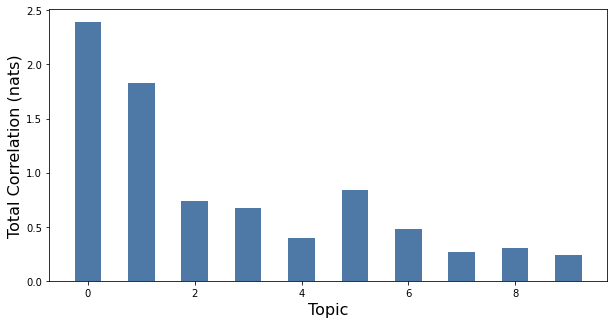

In [36]:
plt.figure(figsize=(10,5))
plt.bar(range(topic_model.tcs.shape[0]), topic_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16)
plt.show()

CorEx seems the most promising and I like the anchors. I'll wrap up this notebook as model discovery and start another to focus solely on CorEx.